In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    display(Markdown(string))

In [3]:
image_dir = Path('D:/Diabetic Retinopathy/APTOS/colored_images')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head(3)

,Filepath,Label
0,D:\Diabetic Retinopathy\APTOS\colored_images\N...,No_DR
1,D:\Diabetic Retinopathy\APTOS\colored_images\N...,No_DR
2,D:\Diabetic Retinopathy\APTOS\colored_images\N...,No_DR


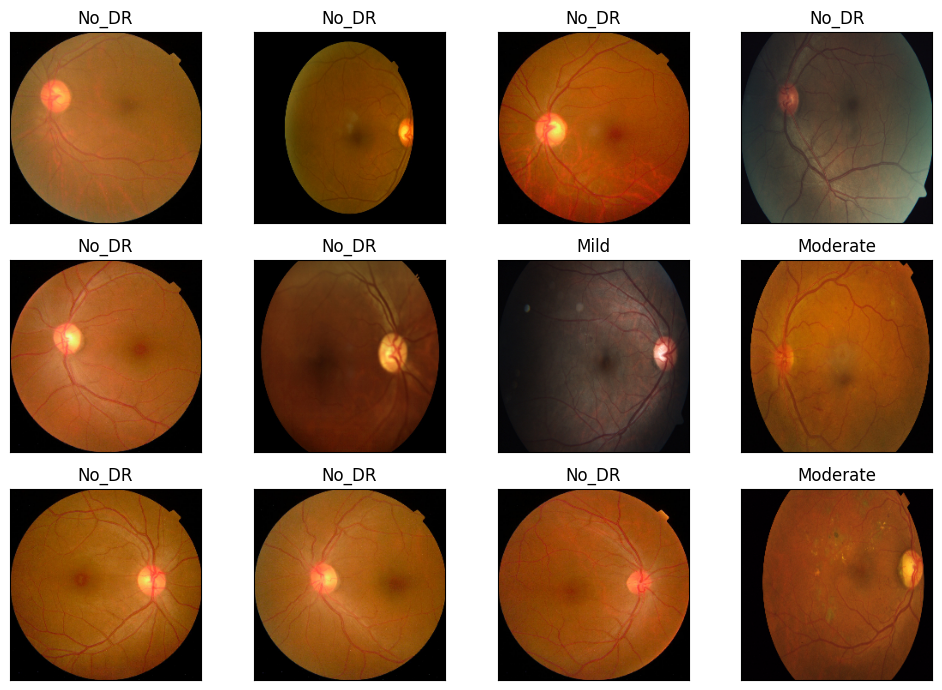

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

C:\Users\sarad\AppData\Local\Temp\ipykernel_22432\4261523045.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


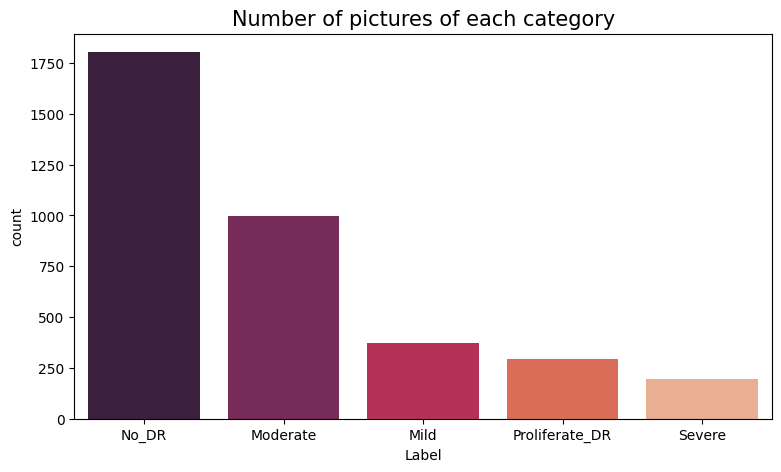

In [6]:
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [7]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [8]:
def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)


In [10]:
models = {
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
}

train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

for name, model in models.items():

    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 210s 2s/step - loss: 0.8299 - accuracy: 0.6908 - val_loss: 0.6189 - val_accuracy: 0.7660
DenseNet169          trained in 209.97 sec
93/93 [==============================] - 45s 466ms/step - loss: 0.7830 - accuracy: 0.7208 - val_loss: 0.6482 - val_accuracy: 0.7629
MobileNet            trained in 44.61 sec
93/93 [==============================] - 277s 3s/step - loss: 1.0970 - accuracy: 0.5954 - val_loss: 0.9250 - val_accuracy: 0.6778
ResNet101            trained in 277.54 sec


In [11]:
models_result = []

for name, v in models.items():
    models_result.append([ name,
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,train_accuracy,val_accuracy,Training time (sec)
0,DenseNet169,0.6908,0.7660,209.97
1,MobileNet,0.7208,0.7629,44.61
2,ResNet101,0.5954,0.6778,277.54


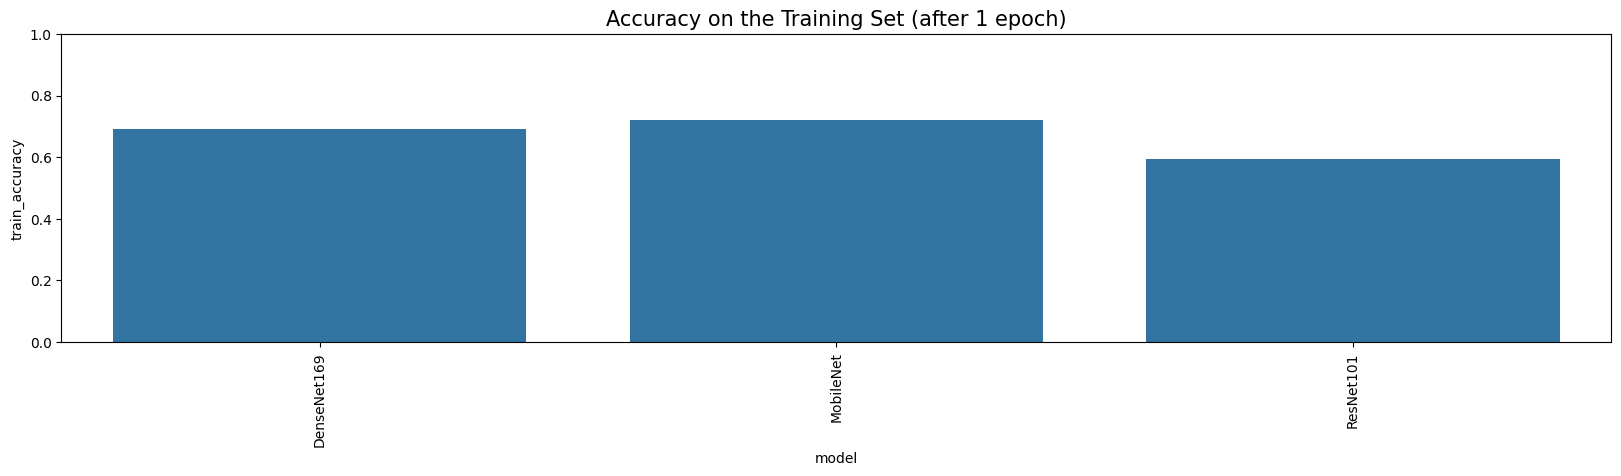

In [12]:
plt.figure(figsize = (20,4))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [13]:
pretrained_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

29084464/29084464 [==============================] - 121s 4us/step


In [14]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
93/93 [==============================] - 173s 2s/step - loss: 0.8215 - accuracy: 0.7067 - auc: 0.9140 - val_loss: 0.6218 - val_accuracy: 0.7812 - val_auc: 0.9529
Epoch 2/10
93/93 [==============================] - 168s 2s/step - loss: 0.6206 - accuracy: 0.7657 - auc: 0.9514 - val_loss: 0.5845 - val_accuracy: 0.7842 - val_auc: 0.9577
Epoch 3/10
93/93 [==============================] - 176s 2s/step - loss: 0.5485 - accuracy: 0.7970 - auc: 0.9620 - val_loss: 0.5501 - val_accuracy: 0.7933 - val_auc: 0.9622
Epoch 4/10
93/93 [==============================] - 173s 2s/step - loss: 0.5174 - accuracy: 0.8061 - auc: 0.9657 - val_loss: 0.5871 - val_accuracy: 0.7994 - val_auc: 0.9576
Epoch 5/10
93/93 [==============================] - 166s 2s/step - loss: 0.5100 - accuracy: 0.8038 - auc: 0.9666 - val_loss: 0.6073 - val_accuracy: 0.7508 - val_auc: 0.9528


In [29]:
model.save('DenseNet.model')

INFO:tensorflow:Assets written to: DenseNet.model\assets


INFO:tensorflow:Assets written to: DenseNet.model\assets


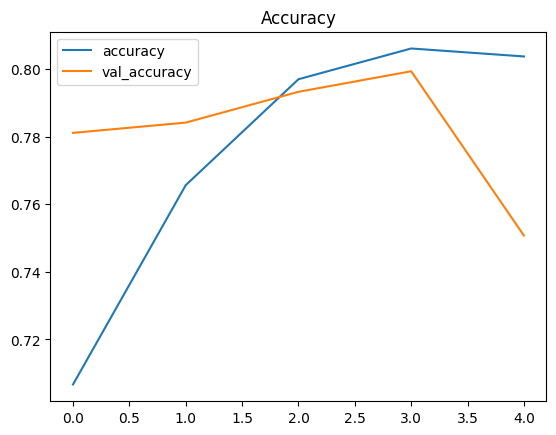

In [20]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

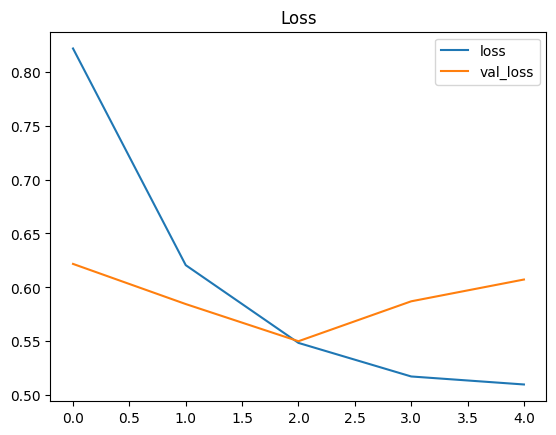

In [16]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [17]:
results = model.evaluate(test_images, verbose=0)

In [18]:
printmd("Test Loss: {:.5f}".format(results[0]))
printmd("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.54716

Accuracy on the test set: 80.11%

In [19]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

12/12 [==============================] - 20s 2s/step


In [26]:
from sklearn.metrics import classification_report

y_true = test_images.classes 
y_pred = model.predict(test_images)  

y_pred = y_pred.argmax(axis=-1)

class_labels = list(test_images.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels)

print(report)


12/12 [==============================] - 20s 2s/step
                precision    recall  f1-score   support

          Mild       0.50      0.45      0.47        31
      Moderate       0.75      0.70      0.73       105
         No_DR       0.95      0.97      0.96       194
Proliferate_DR       0.43      0.76      0.55        21
        Severe       0.33      0.12      0.18        16

      accuracy                           0.80       367
     macro avg       0.59      0.60      0.58       367
  weighted avg       0.80      0.80      0.80       367



1/1 [==============================] - 2s 2s/step
Predicted class: No_dr
Confidence: 0.9523186087608337


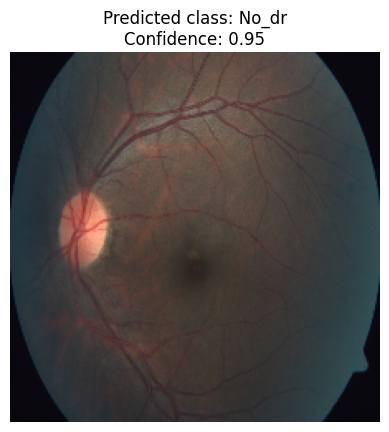

In [34]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("DenseNet.model")  # Replace with the actual path to your trained model

# Load and preprocess the input image
image_path = "D:/Diabetic Retinopathy/APTOS/colored_images/No_DR/0f364b7d4384.png"  # Replace with the actual path to your input image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  # Replace with your actual class labels
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

In [35]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("DenseNet.model")  # Replace with the actual path to your trained model

# Load and preprocess the input image
image_path = "D:/Diabetic Retinopathy/APTOS/colored_images/Mild/1d674e2e32e0.png"  # Replace with the actual path to your input image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  # Replace with your actual class labels
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")


1/1 [==============================] - 2s 2s/step
Predicted class: Moderate
Confidence: 0.6294963359832764


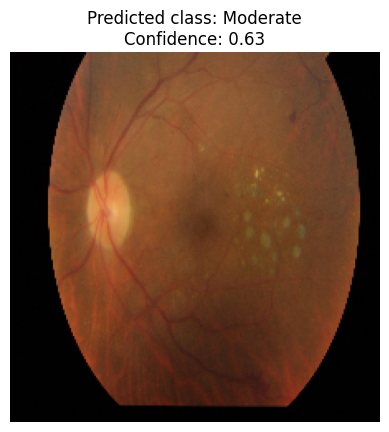

In [36]:
plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

1/1 [==============================] - 2s 2s/step
Predicted class: Proliferate_dr
Confidence: 0.5465141534805298


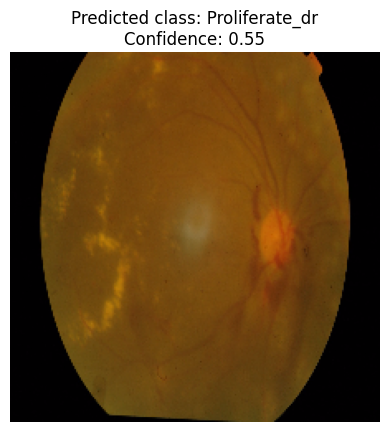

In [37]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("DenseNet.model")  # Replace with the actual path to your trained model

# Load and preprocess the input image
image_path = "D:/Diabetic Retinopathy/APTOS/colored_images/Proliferate_DR/1b32e1d775ea.png"  # Replace with the actual path to your input image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  # Replace with your actual class labels
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()